In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve

# Utilities
from scipy.stats import loguniform, randint
import warnings
warnings.filterwarnings('ignore')

The EDA and data preprocessing steps have been finalized in the V1 notebook!

In [2]:
# --- DATA LOADING AND INITIAL CLEANING ---
print("--- Loading and Cleaning Data ---")
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-Telco-Customer-Churn.csv' not found. Please ensure the file is in the correct directory.")
    exit()


# Drop customerID as it's an identifier
df = df.drop('customerID', axis=1)

# Convert TotalCharges to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']) #(0.2%) 11 rows
df


--- Loading and Cleaning Data ---


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


New feature engineering step:

Collapsing “No internet service” Categories

Many churn datasets have multiple service flags, e.g.:

- `InternetService` ∈ { DSL, Fiber optic, No }
- `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, etc. ∈ { Yes, No, No internet service }

To avoid redundant “No internet service” categories, we can collapse **all** of those secondary columns’ “No internet service” values into a single “No” - because whenever a customer truly has *no* internet, it shows up *both* in `InternetService` and in **every** dependent column.

- **Reduce dimensionality & sparsity**  
  Fewer dummy variables - smaller, denser one-hot matrices - faster training and less over-parameterization.  

- **Eliminate noise & collinearity**  
  Dependent features carry no extra signal beyond the main `InternetService` flag. Keeping them would introduce duplicate information that can cause instability for regularized models and inflate variance.  
  
- **Maintain model parsimony**  
  We avoid wasting model capacity on encoding an outcome that’s already captured elsewhere, allowing the algorithm to focus on truly predictive patterns.

Below we **verify** that assertion, column by column:

In [3]:
# Columns that say “No internet service”
dependent_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Check that whenever dependent_cols == 'No internet service',
# InternetService == 'No'
for col in dependent_cols:
    mask = df[col] == 'No internet service'
    total = mask.sum()
    mismatch = df.loc[mask & (df['InternetService'] != 'No'), ['InternetService', col]]
    print(f"{col}: {total:,} rows -> mismatches: {len(mismatch):,}")
    # If any mismatches > 0, show a few
    if len(mismatch):
        display(mismatch.head())

# 0 mismatches for every column.

OnlineSecurity: 1,520 rows -> mismatches: 0
OnlineBackup: 1,520 rows -> mismatches: 0
DeviceProtection: 1,520 rows -> mismatches: 0
TechSupport: 1,520 rows -> mismatches: 0
StreamingTV: 1,520 rows -> mismatches: 0
StreamingMovies: 1,520 rows -> mismatches: 0


In [4]:
# --- FEATURE ENGINEERING & ENCODING ---
print("--- Performing Feature Engineering ---")

# Collapse redundant categories
cols_to_merge_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols_to_merge_internet:
    df[col] = df[col].replace({'No internet service': 'No'})

# Additional category `No phone service` of multiple lines feature merged to No as from a domain perspective, if no service, there is no line.
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

# Convert binary categorical columns to 0/1 numeric format
binary_text_map = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}

# Define all columns that are binary after our engineering
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'] + cols_to_merge_internet + ['MultipleLines']

for col in binary_cols:
    df[col] = df[col].replace(binary_text_map)

# Convert the target variable 'Churn' to numeric
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

print("Data after feature engineering and encoding:")
display(df.head())

--- Performing Feature Engineering ---
Data after feature engineering and encoding:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [5]:
# --- DATA SPLITTING ---
print("\n--- Splitting Data ---")
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- PREPROCESSING PIPELINE ---
print("--- Setting up Preprocessing Pipeline ---")

# Identify column types AFTER feature engineering
categorical_features_ohe = ['Contract', 'InternetService', 'PaymentMethod']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create the master preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features_ohe)
    ],
    remainder='passthrough' # Let the already-encoded binary columns pass through untouched
)



--- Splitting Data ---
--- Setting up Preprocessing Pipeline ---


In [6]:
# --- MODEL AND HYPERPARAMETER DEFINITIONS ---
print("--- Defining Models and Hyperparameter Grids ---")

# Calculate class weight for imbalance, to be used by XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

param_dist = {
    'Logistic Regression': {
        'model__C': loguniform(1e-4, 1e4),
        'model__class_weight': ['balanced']
    },
    'Random Forest': {
        'model__n_estimators': randint(100, 500),
        'model__max_depth': randint(5, 20),
        'model__class_weight': ['balanced', 'balanced_subsample']
    },
    'XGBoost': {
        'model__learning_rate': loguniform(0.01, 0.3),
        'model__n_estimators': randint(200, 800),
        'model__max_depth': randint(3, 10),
        'model__gamma': [0, 0.1, 0.2],
        'model__scale_pos_weight': [scale_pos_weight] # Critical for imbalance
    },
    'CatBoost': {
        'model__iterations': randint(200, 800),
        'model__learning_rate': loguniform(0.01, 0.2),
        'model__depth': randint(4, 10),
        'model__auto_class_weights': ['Balanced', 'SqrtBalanced'] # Critical for imbalance
    },
    'AdaBoost': {
        'model__n_estimators': randint(50, 500),
        'model__learning_rate': loguniform(0.01, 1.0)
    }
}


--- Defining Models and Hyperparameter Grids ---


In [ ]:


# --- MODEL TRAINING, TUNING, AND EVALUATION ---
print("--- Starting Model Training and Tuning ---")
results = []
first = True 
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    rs = RandomizedSearchCV(pipeline, param_distributions=param_dist[name], n_iter=50,
                            cv=5, scoring='f1', n_jobs=-1, random_state=42)
    
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_

    # just wanted to check features  -- not neccessary
    # Get the preprocessor out of the best pipeline
    preprocessor = best_model.named_steps['preprocessor']
 
    if first:
        feature_names = preprocessor.get_feature_names_out() # just wanted to check features  -- not neccessary
        print(feature_names)
        first = False
    # ---------------------------
    y_pred_final = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    rcv_scores = rs.cv_results_['mean_test_score'] # average f1 across folds
    cv_std = rs.cv_results_['std_test_score'][rs.best_index_]
    
    results.append({
        'Model': name,
        'Best CV F1 Score': rs.best_score_,
        'CV F1 Std': cv_std,
        'Test F1 Score': f1_score(y_test, y_pred_final),
        'Test Precision': precision_score(y_test, y_pred_final),
        'Test Recall': recall_score(y_test, y_pred_final),
        'Test AUC': roc_auc_score(y_test, y_pred_proba)
    })




--- Starting Model Training and Tuning ---
Training Logistic Regression...
['num__tenure' 'num__MonthlyCharges' 'num__TotalCharges'
 'cat__Contract_One year' 'cat__Contract_Two year'
 'cat__InternetService_Fiber optic' 'cat__InternetService_No'
 'cat__PaymentMethod_Credit card (automatic)'
 'cat__PaymentMethod_Electronic check' 'cat__PaymentMethod_Mailed check'
 'remainder__gender' 'remainder__SeniorCitizen' 'remainder__Partner'
 'remainder__Dependents' 'remainder__PhoneService'
 'remainder__MultipleLines' 'remainder__OnlineSecurity'
 'remainder__OnlineBackup' 'remainder__DeviceProtection'
 'remainder__TechSupport' 'remainder__StreamingTV'
 'remainder__StreamingMovies' 'remainder__PaperlessBilling']
Training Random Forest...
Training XGBoost...
Training CatBoost...
Training AdaBoost...


/opt/homebrew/Caskroom/miniconda/base/envs/dsproj/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsproj/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsproj/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsproj/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorit

In [8]:
sns.set_palette('rocket') 


--- Final Model Performance ---


,Model,Best CV F1 Score,CV F1 Std,Test F1 Score,Test Precision,Test Recall,Test AUC
0,Random Forest,0.638285,0.027047,0.632035,0.530909,0.780749,0.840576
1,CatBoost,0.635032,0.023825,0.617920,0.502513,0.802139,0.840450
2,XGBoost,0.632307,0.025945,0.615544,0.502538,0.794118,0.835677
3,Logistic Regression,0.635247,0.023649,0.608342,0.490969,0.799465,0.835313
4,AdaBoost,0.592111,0.020657,0.581395,0.636943,0.534759,0.836599



--- Visualizing Model Performance ---


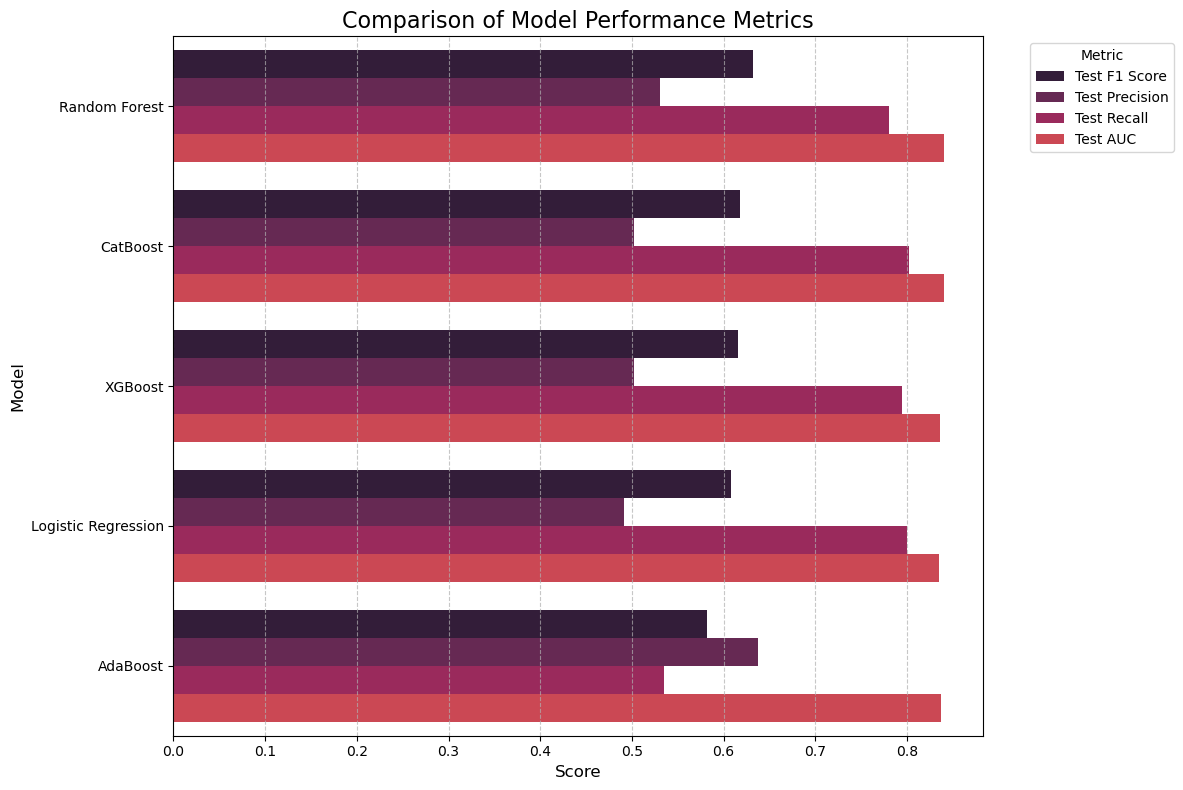

In [9]:
# --- RESULTS DISPLAY AND VISUALIZATION ---

print("\n--- Final Model Performance ---")
results_df = pd.DataFrame(results).sort_values(by='Test F1 Score', ascending=False).reset_index(drop=True)
display(results_df)

# Plotting the results for comparison
print("\n--- Visualizing Model Performance ---")
results_to_plot = results_df[['Model', 'Test F1 Score', 'Test Precision', 'Test Recall', 'Test AUC']]
melted_results = results_to_plot.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Model', hue='Metric', data=melted_results)
plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Experiment with stacking

In [10]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# base learners with class_weight balancing
estimators = [
    ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)),
    ('xgb', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        n_jobs=-1,
        random_state=42
    )),
    ('lgbm', lgb.LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=42)),
]

#  the stacking classifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    cv=5,               
    n_jobs=-1,
    passthrough=True    # include base-model predictions as features
)


stack_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking',     stack_clf)
])


stack_pipeline.fit(X_train, y_train)

y_pred      = stack_pipeline.predict(X_test)
y_pred_proba = stack_pipeline.predict_proba(X_test)[:, 1]

print("Stacking Test F1:      ", f1_score(y_test, y_pred))
print("Stacking Test Precision:", precision_score(y_test, y_pred))
print("Stacking Test Recall:   ", recall_score(y_test, y_pred))
print("Stacking Test AUC:      ", roc_auc_score(y_test, y_pred_proba))


[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002794 seconds.

Stackclassifier with random cv hyperparameter tuning!

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(
        class_weight='balanced', n_estimators=200, n_jobs=-1, random_state=42
    )),
    ('xgb', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        n_estimators=200, n_jobs=-1, random_state=42
    )),
    ('lasso', LogisticRegression(
        penalty='l1', solver='saga', class_weight='balanced',
        C=1.0, max_iter=5000, random_state=42
    )),
    ('cat', CatBoostClassifier(
        verbose=0,
        auto_class_weights='Balanced',
        iterations=200,
        random_state=42
    )),
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        penalty='l2', solver='saga',
        class_weight='balanced', max_iter=2000, random_state=42
    ),
    cv=3,
    n_jobs=1,
    passthrough=True,
    stack_method='predict_proba'
)


stack_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking',     stack_clf)
])


param_dist = {
    'stacking__rf__n_estimators':    [100, 200, 300],
    'stacking__xgb__n_estimators':   [100, 200, 300],
    'stacking__lasso__C':            [0.01, 0.1, 1, 10],
    'stacking__cat__iterations':     [100, 200, 300], 
    'stacking__final_estimator__C':  [0.01, 0.1, 1, 10]

}

rs = RandomizedSearchCV(
    stack_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)
best_stack = rs.best_estimator_

y_pred      = best_stack.predict(X_test)
y_pred_proba = best_stack.predict_proba(X_test)[:, 1]

print("Best CV F1 (stack):     ", rs.best_score_)
print("Stacking Test F1:       ", f1_score(y_test, y_pred))
print("Stacking Test Precision:", precision_score(y_test, y_pred))
print("Stacking Test Recall:   ", recall_score(y_test, y_pred))
print("Stacking Test AUC:      ", roc_auc_score(y_test, y_pred_proba))


Best CV F1 (stack):      0.6370053246391115
Stacking Test F1:        0.6150627615062761
Stacking Test Precision: 0.5051546391752577
Stacking Test Recall:    0.786096256684492
Stacking Test AUC:       0.8377538553923726


In [12]:
import numpy as np
import pandas as pd

# Get out‐of‐fold predictions 
from sklearn.model_selection import cross_val_predict
proba_df = pd.DataFrame({
    name: cross_val_predict(
        est, preprocessor.fit_transform(X_train), y_train,
        cv=5, method='predict_proba', n_jobs=-1
    )[:,1]
    for name, est in estimators  #base learner
})

# Correlation matrix
print(proba_df.corr())

# This analysis clearly indicates why there is no increase in performance of stack, 
# as all the base learners are correlated giving no new signal to the meta model to learn


             rf       xgb     lasso       cat
rf     1.000000  0.881443  0.869840  0.922006
xgb    0.881443  1.000000  0.802057  0.883542
lasso  0.869840  0.802057  1.000000  0.942978
cat    0.922006  0.883542  0.942978  1.000000


In [13]:
# As expected, the base-model probabilities are highly correlated (0.80–0.95), so stacking yields no lift. # This analysis clearly indicates why there is no increase in performance of stack, 
# as all the base learners are correlated giving no new signal to the meta model to learn.